In [354]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import os
import numpy as np
import glob
import pandas as pd

## Plot learning curves

In [389]:
def read_data_from_files(env="*", data_aug="*", seed="*", n_steps=1e5, folder="./new_results"):
    glob_name = os.path.join(folder, f"{env}-s{seed}-{int(n_steps/1000)}k-{data_aug}-pixel")
    
    df = None
    for folder in glob.glob(glob_name):
        exp_name = folder.split('/')[-1]
        env, seed, _, data_aug, _ = exp_name.split('-')
        seed = int(seed[1:])
        
        with open(os.path.join(folder, "eval.log")) as f:
            f_data = [eval(l) for l in f.readlines()]
            episodes, rewards, steps = zip(*[(d['episode'],d['episode_reward'], d['step']) for d in f_data])
            new_df = pd.DataFrame({'env' : len(episodes)*[env],
                                   'data_aug' : len(episodes)*[data_aug],
                                   'seed' : len(episodes)*[seed],
                                   'step' : np.array(steps, dtype=int),
#                                    'episode' : np.array(episodes, dtype=int),
                                   'reward' : np.array(rewards, dtype=float),
                                  })
            df = new_df if df is None else df.append(new_df, ignore_index=True)
    
    return df

def compute_mean_std(df):
    # across seed dim
    return ( df.groupby(['env', 'data_aug', 'step']).reward.mean().unstack(),
            df.groupby(['env', 'data_aug', 'step']).reward.std().unstack() )

ENVS = {
    'reacher_easy' : 'Reacher Easy',
    'cheetah_run' : 'Cheetah Run',
    'finger_spin' : 'Finger Spin',
#     'walker_walk' : 'Walker Walk',
#     'cartpole_swingup' : 'Cartpole Swingup',
#     'cup_catch' : 'Cup Catch',
}

def plot_learning_curves(
         df, 
         envs=ENVS.keys(),
         data_augs=['no_aug', 'aug_discrete', 'aug_continuous', 'aug_even', 
                    'aug_cnn', 'aug_mlp', 'aug_qtarget', 'aug_qpred'],
         subplots_layout=(1,3)
        ):
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_marker("s")
        handle.set_linestyle("None")
    
    mean, std = compute_mean_std(df)
    
    fsize = 4*np.array(subplots_layout)[::-1]
    fsize[0] *= 1.1
    f, axs = plt.subplots(*subplots_layout, figsize=fsize)
    f.subplots_adjust(0,0,1,1)
    
    for env, ax in zip(envs, axs.flatten()):
        for data_aug in data_augs:
            try:
                steps = mean.loc[(env, data_aug)].index.to_numpy()
                mu = mean.loc[(env, data_aug)].to_numpy()
                sig = std.loc[(env, data_aug)].to_numpy()

                ax.plot(steps, mu, label=data_aug)
                ax.fill_between(steps, mu-sig, mu+sig, alpha=0.2)
            except KeyError:
                print(f"no data for {env}-{data_aug}")
        
        ax.set_xticks(steps[::5])
        ax.set_xticklabels([ f"{int(s/1000)}k" for s in steps[::5]])
        ax.set_ylabel('episodic reward')
        ax.set_xlabel('env steps')
        ax.set_title(ENVS[env])
        
    axs.flatten()[-2].legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', 
                             fancybox=False, ncol=len(data_augs),
                             handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)},
                             frameon=False,
                             handletextpad=-0.1,
                            )
    plt.show()


no data for finger_spin-aug_continuous


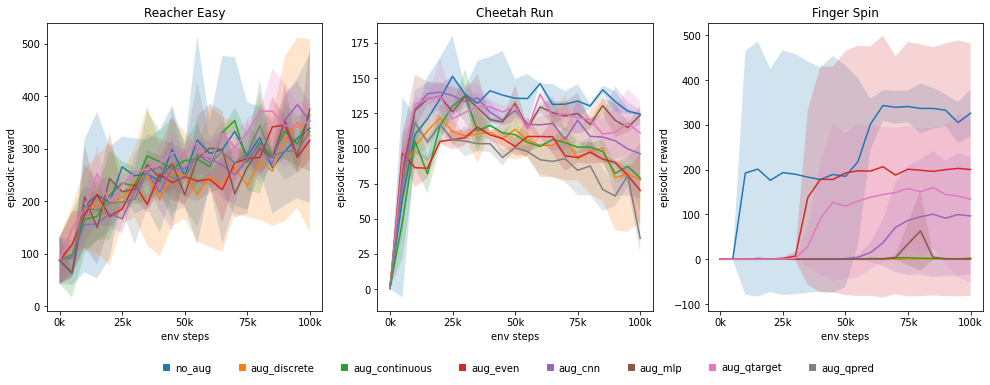

In [390]:
df = read_data_from_files('*', '*', seed='*')
plot_learning_curves(df)


# TABLE COMPARISON

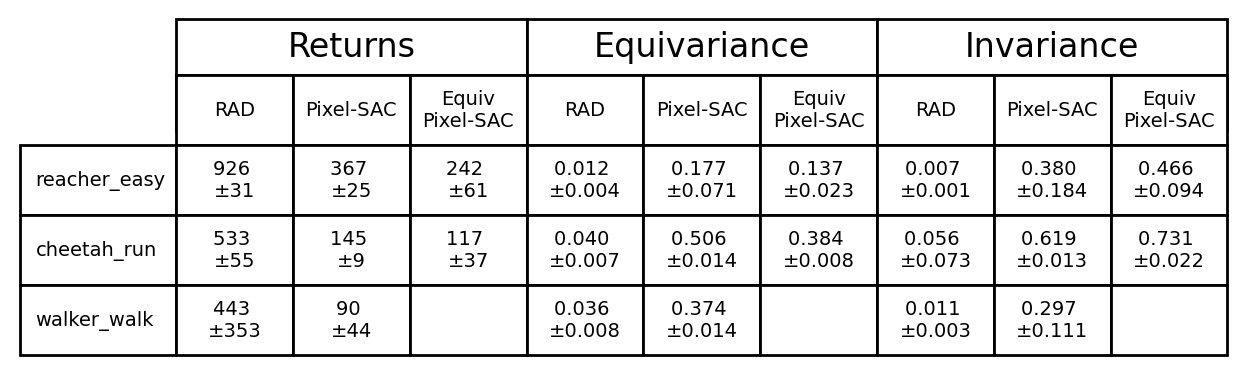

In [2]:
# Table showing 
NETWORK = 'actor'
SHIFT = (1,4) #(0,2), (4,6)
N_STEPS = 100_000
ENVS = ['reacher_easy', 'cheetah_run', 'walker_walk']
METHODS = ['RAD', 'Pixel-SAC', 'Equiv\nPixel-SAC']
_METHODS = ['rad_sac_pixel', 'pixel_sac_pixel', 'pixel_sac_pixel_aa']

SCORE = {}
EQUIV = {}
INV = {}

for f in glob.glob(f"results/*{int(N_STEPS/1000)}k"):
    env, task, seed, agent, encoder, _ = f.split('/')[1].split('-')
    key = f"{env}_{task}-{agent}_{encoder}"

    # SCORE
    eval_fname = next(filter(lambda x: x.find('eval_scores')>-1, glob.glob(f+'/*')))
    try:
        score = list(np.load(eval_fname, allow_pickle=True)[()].values())[0][N_STEPS]['mean_ep_reward']
    except KeyError:
        continue
    SCORE[key] = SCORE.get(key, []) + [score] 
    
    # EQUIV, INV
    # equiv is of 4th conv layer
    # inv is of fc layer
    shiftability = np.load(os.path.join(f, 'shiftability_data.npy'), allow_pickle=True)[()][NETWORK][SHIFT]
    EQUIV[key] = EQUIV.get(key, []) + [shiftability['equiv']['conv4']]
    INV[key] = INV.get(key, []) + [shiftability['inv']['fc']]
    
# calc average and stddev
for key in SCORE.keys():
    SCORE[key] = (np.mean(SCORE[key]), np.std(SCORE[key]))
    EQUIV[key] = (np.mean(EQUIV[key]), np.std(EQUIV[key]))
    INV[key] = (np.mean(INV[key]), np.std(INV[key]))
    

fig, ax = plt.subplots(figsize=(8,2),dpi=200)

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
   
cell_text = []
for env in ENVS:
    cell_text.append([])
    for DATA in [SCORE, EQUIV, INV]:
        for method_key, method in zip(_METHODS, METHODS):
            key = f"{env}-{method_key}"
            if key not in DATA: 
                cell_text[-1].append('')
            else:
                if DATA[key][0] > 1:
                    cell_text[-1].append( f"{DATA[key][0]:.0f} \n±{DATA[key][1]:.0f}" )
                else:
                    cell_text[-1].append( f"{DATA[key][0]:.3f} \n±{DATA[key][1]:.3f}" )

header_1 = plt.table(cellText=[['']*3],
                     colLabels=['Returns', 'Equivariance', 'Invariance'],
                     loc='center',
                     bbox=[0,0.8, 1, 0.4],
                    )
table = plt.table(cellText=cell_text,
                  rowLabels=ENVS,
                  colLabels=METHODS*3,
                  loc='center',
                  colLoc='center',
                  cellLoc='center',
                  bbox=[0,0, 1, 1],
                 )
table.set_fontsize(22)
header_1.set_fontsize(12)
plt.tight_layout()

# EQUIV/INVARIANCE BREAKDOWN

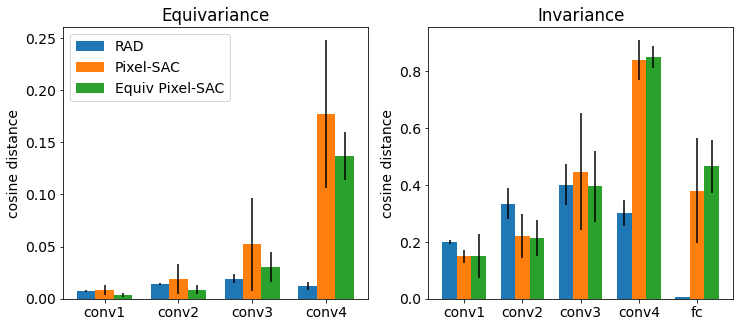

In [4]:
NETWORK = 'actor'
SHIFT = (1,4) #(0,2), (4,6)
N_STEPS = 100_000
ENV = 'reacher_easy'
METHODS = ['RAD', 'Pixel-SAC', 'Equiv Pixel-SAC']
METHODS = {'rad_sac_pixel' : 'RAD',
           'pixel_sac_pixel' : 'Pixel-SAC', 
           'pixel_sac_pixel_aa' : 'Equiv Pixel-SAC',
          }

    
def xvariance_breakdown(env, network, shift, n_steps=100_000):
    INV = {}
    EQUIV = {}
    env_name, task_name = env.split('_')
    for f in glob.glob(f"results/{env_name}-{task_name}*{int(n_steps/1000)}k"):
        _, _,_, agent, encoder, _ = f.split('/')[1].split('-')
        shiftability = np.load(os.path.join(f, 'shiftability_data.npy'), allow_pickle=True)[()][network][shift]
        method = f"{agent}_{encoder}"
        if method in INV:
            for k in INV[method].keys():
                INV[method][k].append(shiftability['inv'][k])
                if k in EQUIV[method]:
                    EQUIV[method][k].append(shiftability['equiv'][k])
        else: 
            INV[method] = {k: [v] for k,v in shiftability['inv'].items() if k!='ln'}
            EQUIV[method] = {k: [v] for k,v in shiftability['equiv'].items()}
            
    for method in INV.keys():
        for k in INV[method].keys():
            INV[method][k] = (np.mean(INV[method][k]), np.std(INV[method][k]))
            if k in EQUIV[method]:
                EQUIV[method][k] = (np.mean(EQUIV[method][k]), np.std(EQUIV[method][k]))
    
    f, ax = plt.subplots(1,2, figsize=(12,5))

    w = 0.25
    for i, data in enumerate([EQUIV, INV]):
        for mi, method_name in enumerate(METHODS.keys()):
            avg = [v[0] for v in data[method_name].values()]
            err = [v[1] for v in data[method_name].values()]
            x_axis = np.arange(len(data[method]))
            ax[i].bar(x_axis + (mi-1.)*w, avg, w, yerr=err, label=METHODS[method_name])
       

        ax[i].set_xticks(x_axis)
        ax[i].set_xticklabels(list(data[method].keys()))
        if i == 0:
            ax[i].legend(loc='upper left')

        ax[i].set_title(['Equivariance','Invariance'][i])
        ax[i].set_ylabel('cosine distance')
    
    plt.savefig(f'plots/{env}_{network}_{int(n_steps/1000)}k_{shift[0]}-{shift[1]}px.png')
    
plt.rcParams.update({'font.size': 14})

xvariance_breakdown(ENV, NETWORK, SHIFT, N_STEPS)